<a href="https://colab.research.google.com/github/Jayasri02Sridharan/Reinsurance-Pricing-Claim-Simulation/blob/main/2_severity_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

### 2. Load Cleaned Data

In [ ]:
df = pd.read_csv("/content/allstate_cleaned_claims.csv")

loss = df["loss_infl_adj"].copy()
loss = loss.replace([np.inf, -np.inf], np.nan).dropna()
loss = loss[loss > 0]

print("Number of claims:", len(loss))
loss.describe(percentiles=[0.5, 0.9, 0.95, 0.99, 0.995])

Number of claims: 188318


,loss_infl_adj
count,188318.000000
mean,3578.480545
std,3463.488994
min,0.916842
50%,2481.119000
90%,7565.592233
95%,10056.748232
99%,16637.184872
99.5%,19873.160160
max,165595.710526


### 3. Plot Loss Distribution

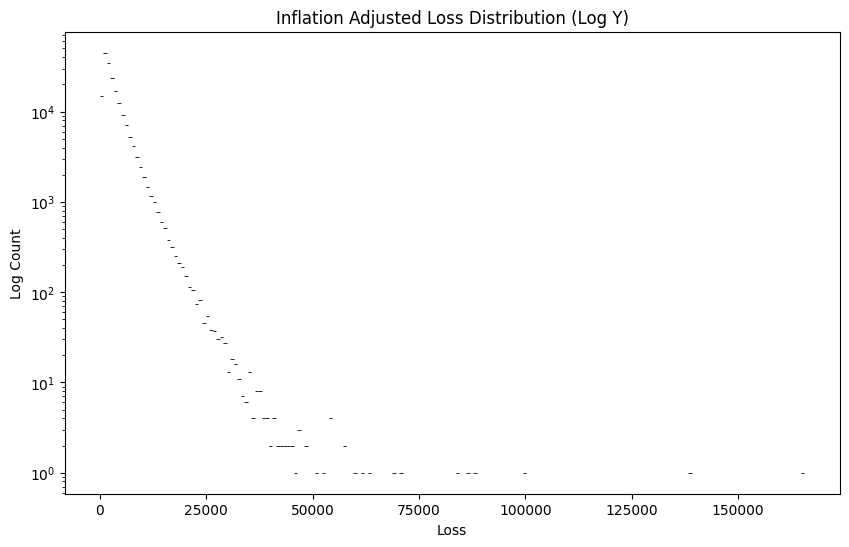

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(loss, bins=200,color="red", alpha=1, edgecolor="black", linewidth=0.6, log_scale=(False, True))
plt.title("Inflation Adjusted Loss Distribution (Log Y)")
plt.xlabel("Loss")
plt.ylabel("Log Count")
plt.show()

### 4. Fit Distributions (MLE)

In [ ]:
# Lognormal
ln_shape, ln_loc, ln_scale = stats.lognorm.fit(loss, floc=0)
# Gamma
ga_shape, ga_loc, ga_scale = stats.gamma.fit(loss, floc=0)
# Weibull
wb_shape, wb_loc, wb_scale = stats.weibull_min.fit(loss, floc=0)

### 5. Compare models with AIC

In [ ]:
def compute_aic(loglik, k):
    return 2*k - 2*loglik

loglik_lognorm = np.sum(stats.lognorm.logpdf(loss, ln_shape, ln_loc, ln_scale))
loglik_gamma   = np.sum(stats.gamma.logpdf(loss, ga_shape, ga_loc, ga_scale))
loglik_weibull = np.sum(stats.weibull_min.logpdf(loss, wb_shape, wb_loc, wb_scale))

aic_table = pd.DataFrame({
    "Distribution": ["Lognormal", "Gamma", "Weibull"],
    "LogLik": [loglik_lognorm, loglik_gamma, loglik_weibull],
    "AIC": [
        compute_aic(loglik_lognorm, 2),
        compute_aic(loglik_gamma, 2),
        compute_aic(loglik_weibull, 2)
    ]
}).sort_values("AIC")

aic_table

,Distribution,LogLik,AIC
0,Lognormal,-1.706543e+06,3.413090e+06
1,Gamma,-1.717648e+06,3.435300e+06
2,Weibull,-1.722805e+06,3.445615e+06


#### Note: Lowest AIC = best fit model

### 6. QQ Plots

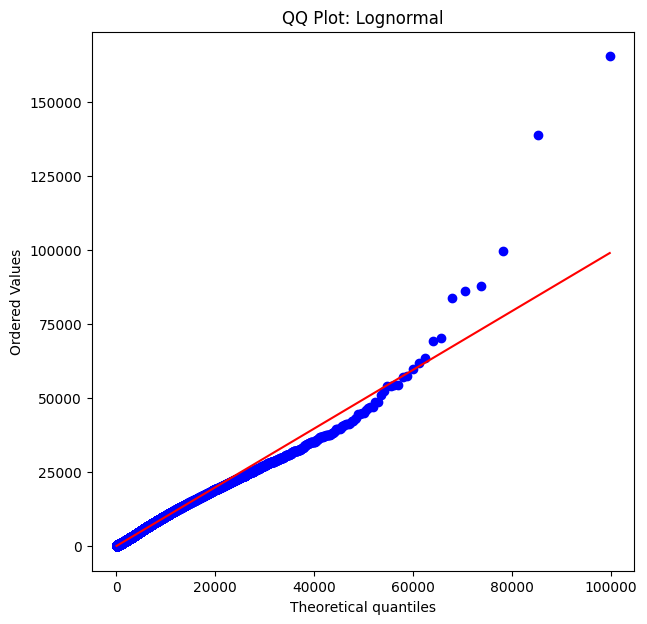

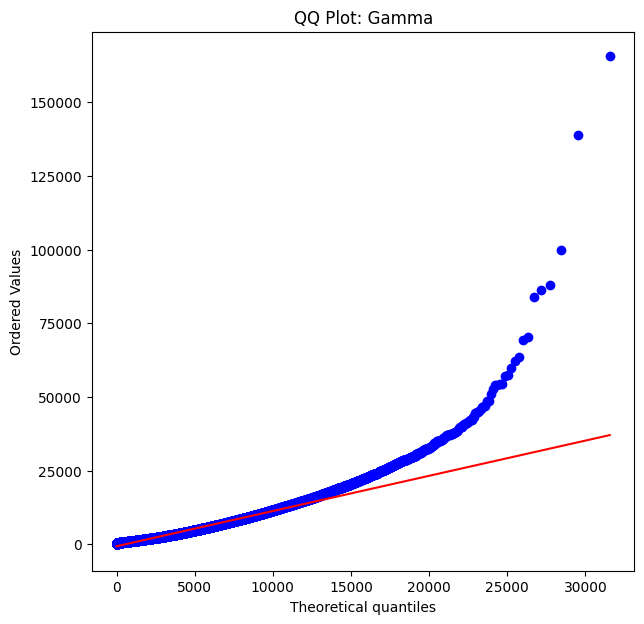

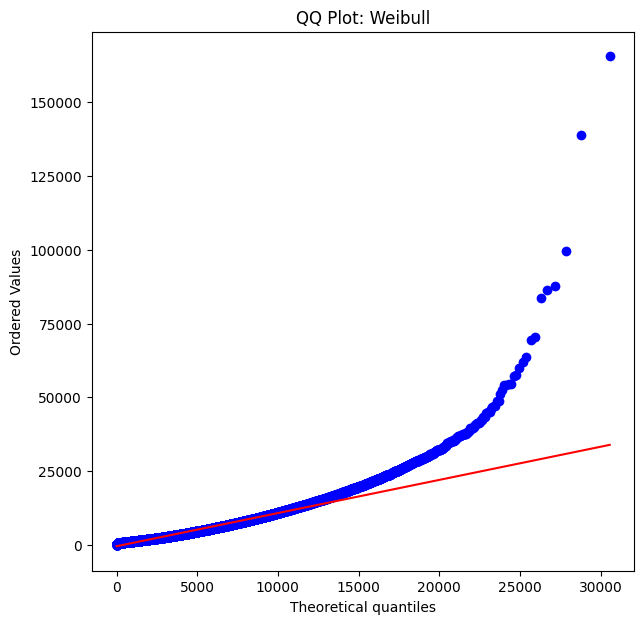

In [ ]:
def qq_plot(data, dist, params, title):
    plt.figure(figsize=(7,7))
    stats.probplot(data, dist=dist, sparams=params, plot=plt)
    plt.title(title)
    plt.show()

qq_plot(loss, stats.lognorm, (ln_shape, ln_loc, ln_scale), "QQ Plot: Lognormal")
qq_plot(loss, stats.gamma, (ga_shape, ga_loc, ga_scale), "QQ Plot: Gamma")
qq_plot(loss, stats.weibull_min, (wb_shape, wb_loc, wb_scale), "QQ Plot: Weibull")

#### Tail deviation = model not suitable for reinsurance pricing.

### 7. Tail modeling with using Pareto (95% threshold)

In [ ]:
u = np.quantile(loss, 0.95)
tail = loss[loss > u]

excess = tail - u

pareto_shape, pareto_loc, pareto_scale = stats.pareto.fit(excess, floc=0)

print("Threshold u:", u)
print("Tail sample size:", len(tail))
print("Pareto alpha (shape):", pareto_shape)

Threshold u: 10056.748232142858
Tail sample size: 9416
Pareto alpha (shape): 0.09708458616650796


#### Lower alpha means heavier tail

### 8. VaR and TVaR

In [ ]:
def var(data, q):
    return np.quantile(data, q)

def tvar(data, q):
    v = var(data, q)
    return data[data > v].mean()

for q in [0.95, 0.99, 0.995]:
    print(f"VaR({q*100:.1f}%) =", var(loss, q))
    print(f"TVaR({q*100:.1f}%) =", tvar(loss, q))
    print("-----")

VaR(95.0%) = 10056.748232142858
TVaR(95.0%) = 14344.383917445284
-----
VaR(99.0%) = 16637.18487199247
TVaR(99.0%) = 22052.05159257951
-----
VaR(99.5%) = 19873.160159821524
TVaR(99.5%) = 26041.573698692064
-----


### 9. Reinsurance layer pricing (XL Pricing)

In [ ]:
def ceded_loss(x, R, L):
    return np.minimum(np.maximum(x - R, 0), L)

In [ ]:
# example
R = var(loss, 0.95)
L = 50000

ceded = ceded_loss(loss.values, R, L)

print("Retention (R):", R)
print("Limit (L):", L)
print("Expected Ceded Loss (Pure Premium):", np.mean(ceded))
print("Probability of Attachment:", np.mean(loss.values > R))

Retention (R): 10056.748232142858
Limit (L): 50000
Expected Ceded Loss (Pure Premium): 212.64753689855598
Probability of Attachment: 0.050000531016684543


### 10. Retention Sensitivity Table (Loss Cost Curve)

In [ ]:
limit = 50000
retentions = np.quantile(loss, np.linspace(0.80, 0.995, 15))

results = []
for R in retentions:
    ceded = ceded_loss(loss.values, R, limit)
    results.append({
        "Retention": R,
        "Expected_Ceded_Loss": np.mean(ceded),
        "Attach_Probability": np.mean(loss.values > R)
    })

pricing_table = pd.DataFrame(results)
pricing_table

,Retention,Expected_Ceded_Loss,Attach_Probability
0,5241.303639,724.359112,0.200002
1,5479.961357,678.337102,0.186074
2,5729.946962,633.611896,0.172145
3,6009.836734,587.401045,0.158216
4,6303.945685,542.937932,0.144288
5,6645.497220,496.100203,0.130359
6,7031.419518,448.575891,0.116431
7,7480.274657,399.518372,0.102502
8,7979.727023,351.906716,0.088574
9,8580.033807,303.084062,0.074645


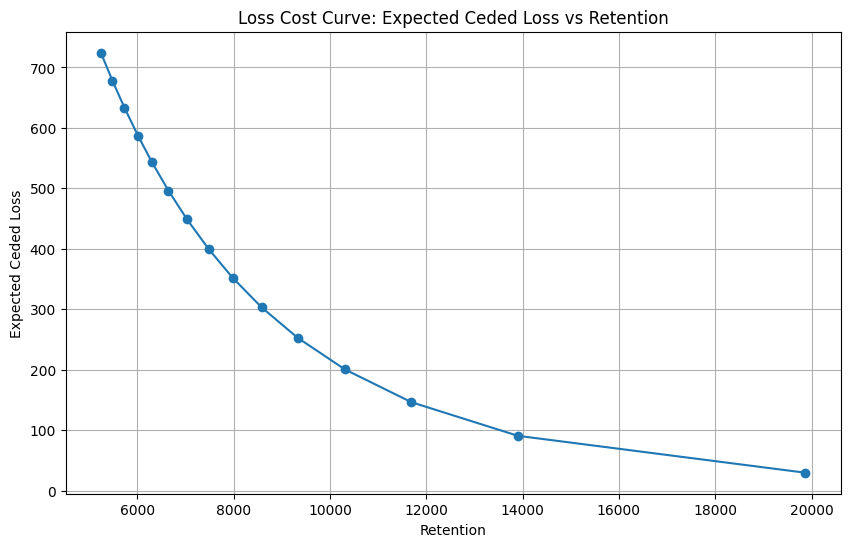

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pricing_table["Retention"], pricing_table["Expected_Ceded_Loss"], marker="o")
plt.title("Loss Cost Curve: Expected Ceded Loss vs Retention")
plt.xlabel("Retention")
plt.ylabel("Expected Ceded Loss")
plt.grid(True)
plt.show()

### 11. Premium with Loading


In [ ]:
loading = 0.30  # 30% risk loading
pricing_table["Premium_with_Loading"] = pricing_table["Expected_Ceded_Loss"] * (1 + loading)

pricing_table

,Retention,Expected_Ceded_Loss,Attach_Probability,Premium_with_Loading
0,5241.303639,724.359112,0.200002,941.666846
1,5479.961357,678.337102,0.186074,881.838233
2,5729.946962,633.611896,0.172145,823.695464
3,6009.836734,587.401045,0.158216,763.621358
4,6303.945685,542.937932,0.144288,705.819311
5,6645.497220,496.100203,0.130359,644.930264
6,7031.419518,448.575891,0.116431,583.148658
7,7480.274657,399.518372,0.102502,519.373883
8,7979.727023,351.906716,0.088574,457.478730
9,8580.033807,303.084062,0.074645,394.009280


In [ ]:
import os
os.makedirs("outputs/tables", exist_ok=True)

pricing_table.to_csv("outputs/tables/layer_pricing_table.csv", index=False)
print("Saved outputs/tables/layer_pricing_table.csv")

Saved outputs/tables/layer_pricing_table.csv
